In [1]:
from oldModel import OrientationWei, sensory_noise_dist, sensory_noise_dist_sample
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
plt.rcParams['lines.linewidth'] = 3
import seaborn as sns
# sns.set_context('talk')
import scipy.stats as ss
import math

from scipy.integrate import simpson, trapezoid
import numpy as np
from scipy.interpolate import UnivariateSpline, interp1d
from ipywidgets import interact
import ipywidgets as widgets
from scipy.stats import gaussian_kde

In [2]:
import riskDualObserverShared as model
import tools as tools

2.0000000000000027


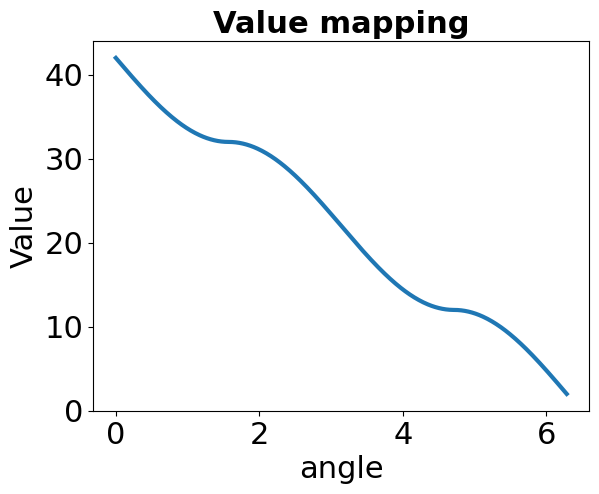

In [44]:
type = "prior"
line_frac = 0.0

plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, type, line_frac))
# plt.plot(tools.stim_ori_grid, tools.value_function_ori(tools.stim_ori_grid, "cdf_prior", line_frac))
# plt.plot(tools.stim_ori_grid,(integrate.cumtrapz(tools.prior_ori(tools.stim_ori_grid), tools.stim_ori_grid, initial=0.0))*tools.factor_val+tools.min_val)

print(min(tools.value_function_ori(tools.stim_ori_grid, type, line_frac)))

plt.ylabel("Value")
plt.xlabel("angle")
plt.title("Value mapping", size = 22,fontweight="bold")

plt.savefig('/Users/sbedi/Downloads/teig.png',dpi=300, bbox_inches = "tight")

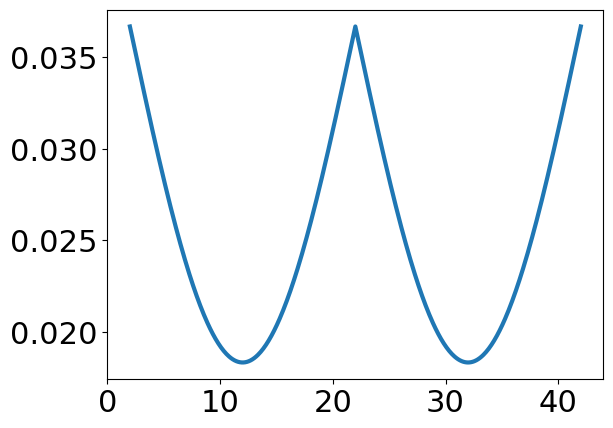

In [5]:
plt.plot(model.prior_val("linearIncrease")[0], model.prior_val("linearIncrease")[1])
# model.prior_val("inversePrior")[0]

(1, 501)

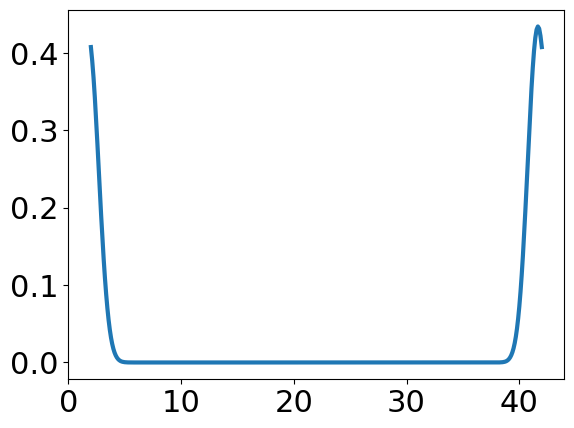

In [12]:

theta0 = 1.99*np.pi
kappa_s = 100

bin_centers, ps = tools.ori_to_val_dist(model.stim_ori_grid, model.stimulus_ori_noise(theta0, kappa_s, model.stim_ori_grid), "cdf_prior", monotonic=True)


plt.plot(bin_centers, ps[0])

np.shape(bin_centers)
np.shape(ps)



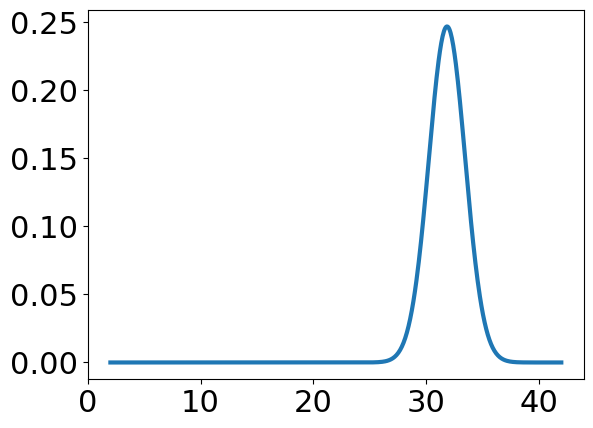

In [15]:
theta0 = 100/90*np.pi*np.pi
kappa_s = 1000
kappa_r = 32
type = "cdf_prior"

# rep_val_grid, p_mVal_given_Val0, p_mVal_given_Val = model.val_encoded(theta0, kappa_s, kappa_r, type)

rep_val_grid, stim_val_grid, p_value_est_given_val0 = model.value_bayesian_decoding(theta0, kappa_s, kappa_r, type)

# p_mOri_given_theta0, p_mOri_given_theta = model.MI_orientation_encoding(theta0, kappa_s, kappa_r)

plt.plot(stim_val_grid, p_value_est_given_val0[0])

# plt.plot(p_mOri_given_theta0[0])


array([[0.92567317, 0.96731987]])

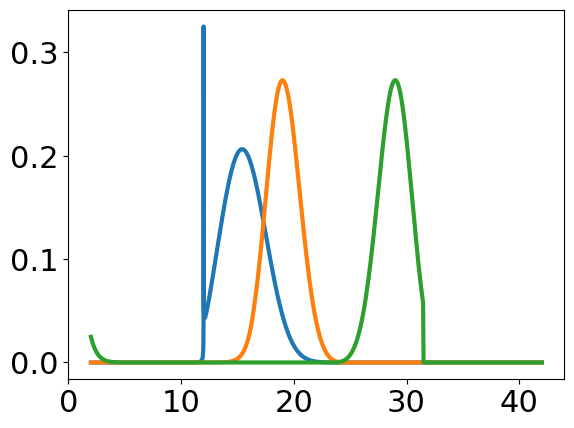

In [55]:
theta0 = 70./90.*np.pi
theta1 = [100./90.*np.pi, 170./90*np.pi]
kappa_s = 10000
kappa_r = 32
type = "prior"
risk_prob = 0.75


rep_val_grid, safe_value, safe_prob = model.value_bayesian_decoding(theta0, kappa_s, kappa_r, type)
risky_value, risky_prob = model.risky_value_dist(theta1, kappa_s, kappa_r, risk_prob, type)

plt.plot(safe_value, safe_prob[0])
plt.plot(safe_value, risky_prob[0])
plt.plot(safe_value, risky_prob[1])

p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
p_chose_risky

# tools.get_rnp(safe_value, risky_value)
# plt.plot(rep_val_grid, p_mVal_given_Val0[0])
# plt.plot(stim_val_grid, p_val_given_mVal[40])
# plt.plot(stim_val_grid, abs(trapezoid((p_mVal_given_Val0[:,np.newaxis,:]*p_val_given_mVal[np.newaxis, ...]),rep_val_grid,axis = 2)[0]))
# plt.plot(stim_val_grid, p_value_est_given_val0[0])

# Uncovering risk attitudes

# Comaparing two models - Both safe and risky option with same noise type

In [3]:
def rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])-1
    start = int(experimentEffects[0:2])+1
    end = end/90.*np.pi
    start = start/90.*np.pi
    
    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = float(tools.inverse_monotonic(tools.value_function_ori(start, type)/1.5, type))
        safe_angles =  np.linspace(end, start_safe, int((end*90/np.pi-start_safe*90/np.pi+1)/3))
    else:
        end_safe = float(tools.inverse_monotonic(tools.value_function_ori(end, type)/1.5, type))
        safe_angles =  np.linspace(start, end_safe, int((start*90/np.pi+end_safe*90/np.pi-1)/3))
    
    # print("safe angles - ",safe_angles)
    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        interval = abs(float(tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)))
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval), 20)
        else:
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]+(interval), 20)

        # print("range - ", rangeOri)
        # print("interval - ",interval)

        safeVal = float(tools.value_function_ori(safe_angles[i], type))
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        safe_value, safe_prob = model.safe_value_dist(safe_angles[i], stim_noise, rep_noise , type)
        rr, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)
        print("safe angle - ", safe_angles[i]*90./np.pi)
        print(p_chose_risky[0,::2])
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
        print(rnp[i])

    return safe_angles, safeVals, rnp



safe angle -  1.0
[5.96497073e-12 1.07639878e-10 1.82014908e-09 2.65629108e-08
 3.13961941e-07 2.89233781e-06 2.04056203e-05 1.09955377e-04
 4.56040251e-04 1.47715531e-03]
0.75
safe angle -  4.104761904761904
[1.92291519e-12 4.19587088e-11 7.68643525e-10 1.10152372e-08
 1.19670255e-07 9.75641892e-07 5.99388357e-06 2.81235503e-05
 1.02687941e-04 2.97999120e-04]
0.75
safe angle -  7.209523809523809
[8.03194933e-12 4.41735073e-11 5.89928078e-10 6.62662416e-09
 5.56536254e-08 3.51493504e-07 1.70081735e-06 6.44399992e-06
 1.95481198e-05 4.85111755e-05]
0.75
safe angle -  10.314285714285713
[7.27377318e-10 7.66021838e-10 1.15749118e-09 4.10192698e-09
 2.08376157e-08 9.41377601e-08 3.46483987e-07 1.04247322e-06
 2.60671222e-06 5.51200511e-06]
0.003955639039826225
safe angle -  13.41904761904762
[4.14478178e-08 4.14759472e-08 4.16524251e-08 4.25207614e-08
 4.59318062e-08 5.68143520e-08 8.54685900e-08 1.48639772e-07
 2.66667915e-07 4.55242527e-07]
0.00458811242586577
safe angle -  16.5238095238

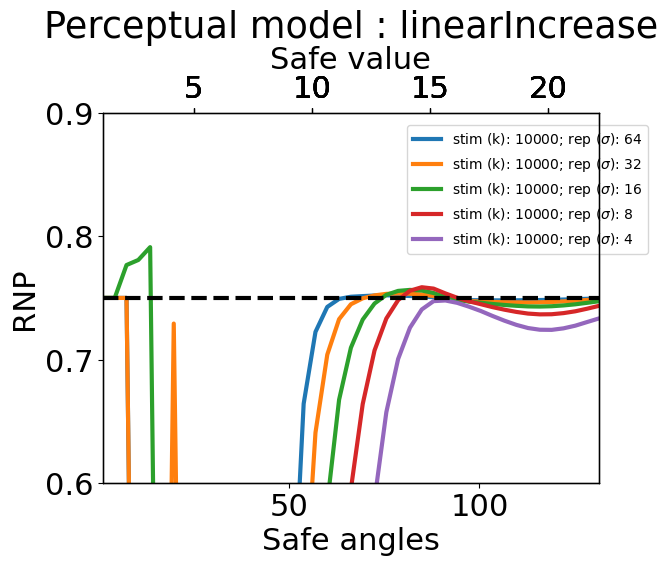

In [4]:
# setting parameters
experimentEffects = "00to180"#"00to45"
risk_prob = 0.75
type = "linearIncrease" 

# changeable parameters
stim_list = [10000]
rep_list = [64, 32, 16, 8, 4]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for stim_noise in stim_list:
    for rep_noise in rep_list:

        safe_angles, safeVals, rnp = rnp_across_safeVals(stim_noise, rep_noise, type, risk_prob, experimentEffects)
        ax1.set_ylim(0.6, 0.9)
        ax1.set_xlim(min(safe_angles*90./np.pi), max(safe_angles*90./np.pi))

        text = "stim (k): "+ str(stim_noise)+"; rep ($\sigma$): "+str(rep_noise)
        ax1.plot(safe_angles[:]*90./np.pi, rnp[:], label = text)


        ax2 = ax1.twiny()
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            ax2.set_xlim(max(safeVals), min(safe_angles))

        ax2.plot(safeVals, np.ones(len(safeVals))/1.3, alpha=0.0)

ax1.axhline(risk_prob, c='k', ls='--')
ax1.legend(bbox_to_anchor=(0.6, 0.6), prop={'size': 10})

ax2.set_xlabel("Safe value")
ax1.set_xlabel("Safe angles")
ax1.set_ylabel("RNP")
ax1.set_title("Perceptual model : " + type) 


plt.savefig('/Users/sbedi/Downloads/testfigShared.png',dpi=300, bbox_inches = "tight")

# Exaggerated risks by taking opposing noise regimes

In [27]:

def find_rnp_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects):

    # Getting all the values from actual transformation
    end = int(experimentEffects[-3:])
    start = int(experimentEffects[0:2])

    if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
        start_safe = tools.inverse_monotonic(tools.value_function_ori(start/90.*np.pi, type)/1.5, type)
        safe_angles =  np.linspace(end/90., start_safe/90., int(end-start_safe+1))*np.pi

    rnp = np.zeros(len(safe_angles))
    safeVals = np.zeros(len(safe_angles))

    for i in range(len(safe_angles)):
        if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
            interval = tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type), type)-tools.inverse_monotonic(tools.value_function_ori(safe_angles[i], type)*1.5, type)
            rangeOri = np.linspace(safe_angles[i],  safe_angles[i]-(interval/90.*np.pi), 20)

        safeVal = tools.value_function_ori(safe_angles[i], type)
        safeVals[i] = safeVal
        val_range = tools.value_function_ori(rangeOri, type)
        riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

        # getting inferred safe values
        rep_val_grid, safe_value, safe_prob = model.value_bayesian_decoding(safe_angles[i], safeNoise[0], safeNoise[1], type)
        safe_value, risky_prob = model.risky_value_dist((rangeOri), riskyNoise[0], riskyNoise[1], risk_prob, type)

        # Risk attitudes 
        p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

        safeVals[i] = safeVal
        rnp[i] = tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)
    return safe_angles, safeVals, rnp




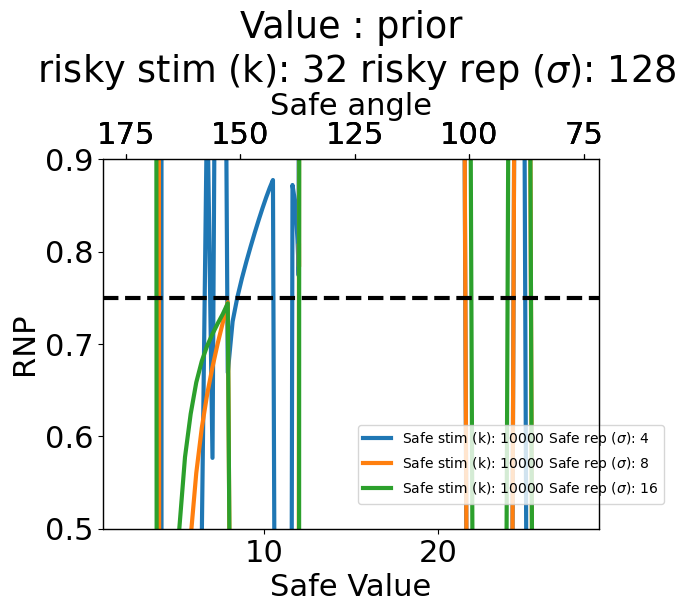

In [22]:

# setting parameters
experimentEffects = "00to180"
risk_prob = 0.75
type = "prior" 

# changeable parameters
high_stim_list = [32]
low_stim_list = [10000]
high_rep_list = [4,8,16]
low_rep_list = [128]

fig = plt.figure()
ax1 = fig.add_subplot(111)

for high_stim_noise in high_stim_list:
    for high_rep_noise in high_rep_list:
        for low_stim_noise in low_stim_list:
            for low_rep_noise in low_rep_list:

                safeNoise = [low_stim_noise, high_rep_noise]
                riskyNoise = [high_stim_noise, low_rep_noise]


                safe_angles, safeVals, rnp = find_rnp_diffNoises(safeNoise, riskyNoise, type, risk_prob, experimentEffects)

                ax1.set_ylim(0.5, 0.9)

                text = "Safe stim (k): "+ str(safeNoise[0])+" Safe rep ($\sigma$): "+str(safeNoise[1])
                # text = "Risky stim (k): "+ str(riskyNoise[0])+"; Risky rep ($\sigma$): "+str(riskyNoise[1])
                ax1.plot(safeVals[:], rnp[:], label = text)

                ax2 = ax1.twiny()
                if (type=="prior" or type=="linearPrior" or type=="curvedPrior"):
                    ax2.set_xlim(max(safe_angles*90./np.pi), min(safe_angles*90./np.pi))

                ax2.plot(safe_angles*90./np.pi, np.ones(len(safe_angles))/1.3, alpha=0.0)


ax1.axhline(risk_prob, c='k', ls='--')

ax1.legend(bbox_to_anchor=(0.5, 0.3), prop={'size': 10})
ax2.set_xlabel("Safe angle")
ax1.set_xlabel("Safe Value")
ax1.set_ylabel("RNP")
# if len(safeNoise[0])==1 and len(safeNoise[1])==1:
# ax1.set_title("Value : " + type + "\n safe stim (k): "+str(safeNoise[0])+"; safe rep ($\sigma$): "+str(safeNoise[1]))
# else:
ax1.set_title("Value : " + type + "\n risky stim (k): "+str(riskyNoise[0])+" risky rep ($\sigma$): "+str(riskyNoise[1]))
plt.savefig('/Users/sbedi/Downloads/testfig1.png',dpi=300, bbox_inches = "tight")

In [29]:
tools.value_function_ori(150./90.*np.pi, "prior")

array(10.66025404)

# risk of an option

# different noise regimes


In [ ]:
# Prior
# Noise regimes

# In the linear mapping condition, if safe option is displayed with high sensory noise it results in safe option being percieved 
# with low val and if risky is with hig stim noise, it is percieved with higher value - risk seekinfg behavior



# changeable parameters
high_stim_noise = 32
low_stim_noise = 1000
high_rep_noise = 32
low_rep_noise = 128

risk_prob = 0.75
type = "linearPrior"   

# Getting all the values from actual transformation
rangeOri = np.linspace(39/90., 22/90., 100)*np.pi
val_range = model.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*model.value_function_ori(rangeOri, type)

# getting inferred safe values
safe_value, safe_prob = model.safe_value_dist(rangeOri[0], high_stim_noise, low_rep_noise , type, interpolation_kind = "linear", bins=25)

risky_value, risky_prob = model.risky_value_dist((rangeOri), low_stim_noise, high_rep_noise, risk_prob, type, interpolation_kind = "linear",  bins=25)

# Risk attitudes 
p_chose_risky = model.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky))#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])


# plt.legend(loc = 'lower right')

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

model.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)

single option risk

In [36]:
def inverse_monotonic(y_0, x = model.stim_grid, y = model.value_function_ori(model.stim_grid, type="prior")):
    indices = np.argsort(y)
    y_sorted = y[indices]
    
    def find_closest_index(y_0):
        i = np.searchsorted(y_sorted, y_0, side='left')
        if i == 0:
            return 0
        elif i == len(y_sorted):
            return len(y_sorted) - 1
        else:
            if y_0 - y_sorted[i-1] < y_sorted[i] - y_0:
                return i - 1
            else:
                return i

    i = find_closest_index(y_0)
    x_inverse = x[indices[i]]*90./np.pi
    
    return x_inverse


In [29]:
# inverse_monotonic(28)*90./np.pi
model.value_function_ori(178/90.*np.pi, "prior")

array(2.69756474)

indifference: 12.594523616947754
safeVal: 10.660254037844386
valrange: [10.66025404 10.73293377 10.80372021 10.87259801 10.93955225 11.00456839
 11.06763235 11.12873046 11.18784947 11.24497656 11.30009934 11.35320588
 11.40428465 11.45332457 11.50031503 11.54524582 11.58810722 11.62888992
 11.66758508 11.70418433 11.73867971 11.77106376 11.80132945 11.82947022
 11.85547997 11.87935306 11.90108432 11.92066903 11.93810294 11.95338229
 11.96650375 11.97746448 11.98626211 11.99289473 11.99736089 11.99965964
 12.00020954 12.00224665 12.00645127 12.01282249 12.02135891 12.0320587
 12.04491952 12.0599386  12.07711268 12.09643802 12.11791045 12.14152531
 12.16727748 12.19516137 12.22517095 12.25729969 12.29154065 12.32788639
 12.36632904 12.40686025 12.44947126 12.4941528  12.54089521 12.58968834
 12.64052162 12.69338403 12.7482641  12.80514994 12.86402921 12.92488916
 12.98771658 13.05249786 13.11921894 13.18786537 13.25842227 13.33087433
 13.40520585 13.48140071 13.5594424  13.63931399 13.72

0.8464197902252906

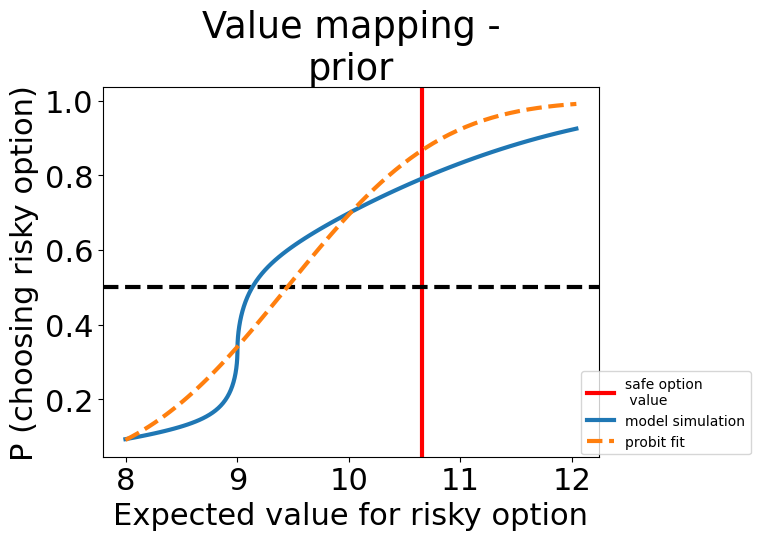

In [18]:

# changeable parameters
stim_noise = 10000
rep_noise = 32

risk_prob = 0.75
type = "prior" 
start = 150

# Getting all the values from actual transformation
interval =  tools.inverse_monotonic(tools.value_function_ori(start/90.*np.pi,type),type) - tools.inverse_monotonic(tools.value_function_ori(start/90.*np.pi,type)*1.5, type)
rangeOri = np.linspace(start/90., (start-interval)/90., 100)*np.pi
val_range = tools.value_function_ori(rangeOri, type)
safeVal = val_range[0]
riskyVal_range = risk_prob*tools.value_function_ori(rangeOri, type)

# getting inferred safe values
rep_val_grid, safe_value, safe_prob = model.value_bayesian_decoding(rangeOri[0], stim_noise, rep_noise , type)

risky_value, risky_prob = model.risky_value_dist((rangeOri), stim_noise, rep_noise, risk_prob, type)

# Risk attitudes 
p_chose_risky = tools.diff_dist(safe_value, risky_prob, safe_prob)

# The value of the safe option
plt.axvline(safeVal, c='r', label = "safe option\n value")
# Where the risky option value is the same as the safe option value,
# the probability of chosing should have been 0.5 i there were no biases at all.
plt.axhline(0.5, c='k', ls='--')
# plt.ylim(0.4,0.6)

# Plotting the risky option value throughout the range and comparing where it crosses the 0.5 probability mark
# and whether it is equal to the actual rational equilibrium that would have been without biases.
plt.plot(riskyVal_range, np.squeeze(p_chose_risky), label = "model simulation")#, label=['rep',kappa_r, "stim (deg)",round(kappa_s*180,2)])

from scipy.optimize import minimize

y = p_chose_risky.ravel()
x = val_range.ravel()


def get_probit(x, intercept, slope):
    return ss.norm(0.0, 1.0).cdf(intercept + slope*x)

def cost(xs, ps, intercept, slope):
    return np.sum((get_probit(xs, intercept, slope) - ps)**2)

def cost_(pars, *args):
    intercept, slope = pars
    return cost(x, y, intercept, slope)

result = minimize(cost_, (-safeVal/risk_prob, 1.0), method='L-BFGS-B')

intercept_est, slope_est = result.x

indifference_point = -intercept_est/slope_est

rnp = safeVal / indifference_point

plt.plot(riskyVal_range, get_probit(x, intercept_est, slope_est), "--", label = "probit fit")

plt.legend(bbox_to_anchor=(0.95, 0.25), prop={'size': 10})

plt.xlabel("Expected value for risky option")
plt.ylabel("P (choosing risky option)")
plt.title("Value mapping -\n" + type) 

plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

print("indifference:", indifference_point)
print("safeVal:", safeVal)
print("valrange:", val_range)
tools.get_rnp(safeVal, val_range, p_chose_risky, risk_prob)

In [32]:
theta0 = model.stim_grid #0.8
# theta0 = theta0[:-1]
kappa1 =10000
kappa2 = 16

# E_theta_given_theta0 = model.expected_thetahat_theta0(theta0, kappa1, kappa, normalize = False)
# plt.plot(theta0*90./np.pi, (E_theta_given_theta0 - theta0)*90./np.pi, label = "Low stim")

# E_theta_given_theta0 = model.expected_thetahat_theta0(theta0, kappas1, kappar1, normalize = False)
# plt.plot(theta0[1:]*90./np.pi, (E_theta_given_theta0 - theta0)[1:]*90./np.pi, label = "Low stim, low rep")


E_theta_given_theta0 = model.expected_thetahat_theta0(theta0, kappa1, kappa2, normalize = False)
plt.plot(theta0[1:]*90./np.pi, (E_theta_given_theta0 - theta0)[1:]*90./np.pi, label = "Low stim, high rep")



E_theta_given_theta0 = model.expected_thetahat_theta0(theta0, kappa2, kappa1, normalize = False)
plt.plot(theta0[1:]*90./np.pi, (E_theta_given_theta0 - theta0)[1:]*90./np.pi, label = "High stim, low rep")




plt.ylim(2.0,-2.0)

plt.axvline(22.5, c='k')
plt.axvline(67.5, c='k')
# plt.axvline(112.5, c='k')
# plt.axvline(157.5, c='k')


plt.legend(bbox_to_anchor=(1., 1.0))

plt.title('relative bias-stimulus noise\n Our code, our method')
plt.xlabel("Presented $\Theta$")
plt.ylabel("Mean bias")
# plt.savefig('/Users/sbedi/Downloads/testfig.png',dpi=300, bbox_inches = "tight")

AttributeError: module 'riskDualObserverShared' has no attribute 'stim_grid'